In [9]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit

# Load and check data

In [10]:
PROCESSED_DATA_FOLDER = "data/4_all_data_preprocessed"
DATASET_FILE = "all_features"

In [11]:
# Load dataset
dataset = pickle.load(open(f"{PROCESSED_DATA_FOLDER}/{DATASET_FILE}.pkl", "rb"))

In [12]:
# Check the size of the data
dataset.shape

(192867, 760)

In [13]:
# Check preview the dataset
dataset.head()

,city_resolvedAddress,day_datetime,isw_date_tomorrow_datetime,event_indicator,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,...,isw_work,isw_would,isw_wound,isw_year,isw_yet,isw_yevgeni,isw_zaporizhia,isw_zaporizhzhia,isw_znpp,isw_zone
0,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
1,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
2,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
3,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0
4,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,False,6.3,-0.3,2.2,-1.2,78.3,0.2,...,0.0,0.0,0.0,0.0,0.170576,0.0,0.0,0.0,0.0,0.0


In [14]:
# Check summary of dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192867 entries, 0 to 192866
Columns: 760 entries, city_resolvedAddress to isw_zone
dtypes: Sparse[float64, 0](718), bool(1), float64(38), object(3)
memory usage: 841.3+ MB


In [15]:
dataset.dtypes

city_resolvedAddress                      object
day_datetime                              object
isw_date_tomorrow_datetime                object
event_indicator                             bool
day_tempmax                              float64
                                     ...        
isw_yevgeni                   Sparse[float64, 0]
isw_zaporizhia                Sparse[float64, 0]
isw_zaporizhzhia              Sparse[float64, 0]
isw_znpp                      Sparse[float64, 0]
isw_zone                      Sparse[float64, 0]
Length: 760, dtype: object

In [16]:
# Check nan
dataset.isna().sum()

city_resolvedAddress          0
day_datetime                  0
isw_date_tomorrow_datetime    0
event_indicator               0
day_tempmax                   0
                             ..
isw_yevgeni                   0
isw_zaporizhia                0
isw_zaporizhzhia              0
isw_znpp                      0
isw_zone                      0
Length: 760, dtype: int64

In [17]:
# Sort dataset by date
dataset['day_datetime'] = pd.to_datetime(dataset['day_datetime'])
dataset = dataset.sort_values(by='day_datetime')
dataset.day_datetime.describe(datetime_is_numeric=True)

count                           192867
mean     2022-08-02 23:32:38.163916288
min                2022-02-25 00:00:00
25%                2022-05-10 00:00:00
50%                2022-08-02 00:00:00
75%                2022-10-24 00:00:00
max                2023-01-20 00:00:00
Name: day_datetime, dtype: object

In [18]:
# Extract relevant date features
dataset['year'] = dataset['day_datetime'].dt.year
dataset['month'] = dataset['day_datetime'].dt.month
dataset['day'] = dataset['day_datetime'].dt.day
dataset['day_of_week'] = dataset['day_datetime'].dt.dayofweek

dataset['season'] = (dataset['day_datetime'].dt.month % 12 // 3).replace({0: 'winter', 1: 'spring', 2: 'summer', 3: 'fall'})

dataset = pd.get_dummies(dataset, columns=['season'])

In [19]:
# Translate city names
dataset.rename(columns = {'city_resolvedAddress':'city'}, inplace=True)
dataset['city'].unique()

array(['Луцьк, Луцький район, Україна', 'Житомир, Україна',
       'Рівне, Україна', 'Полтава, Україна', 'Тернопіль, Україна',
       'Ужгород, Ужгородський район, Україна', 'Донецьк, Україна',
       'Запоріжжя, Україна', 'Суми, Україна', 'Черкаси, Україна',
       'Вінниця, Україна', 'Львів, Україна', 'Івано-Франківськ, Україна',
       'Херсон, Україна', 'Київ, Україна', 'Дніпро, Україна',
       'Чернівці, Україна', 'Кропивницький, Україна', 'Харків, Україна',
       'Миколаїв, Україна', 'Хмельницька область, Україна',
       'Одеса, Україна', 'Чернігів, Україна'], dtype=object)

In [20]:
region_dict = {
    "Київ, Україна" : 'Kyiv', 
    "Миколаїв, Україна" : 'Mykolaiv',
    "Дніпро, Україна": 'Dnipro',
    "Харків, Україна" : 'Kharkiv', 
    "Житомир, Україна": 'Zhytomyr',
    "Кропивницький, Україна": 'Kropyvnytskyi',
    "Запоріжжя, Україна": 'Zaporizhzhia',
    "Полтава, Україна": 'Poltava',
    "Чернігів, Україна": 'Chernihiv',
    "Одеса, Україна": 'Odesa',
    "Хмельницька область, Україна": 'Khmelnytskyi',
    "Черкаси, Україна": 'Cherkasy',
    "Суми, Україна": 'Sumy',
    "Вінниця, Україна": 'Vinnytsia',
    "Херсон, Україна": 'Kherson',
    "Львів, Україна": 'Lviv',
    "Луцьк, Луцький район, Україна": 'Lutsk',
    "Рівне, Україна": 'Rivne',
    "Івано-Франківськ, Україна": 'Ivano-Frankivsk',
    "Тернопіль, Україна": 'Ternopil',
    "Чернівці, Україна": 'Chernivtsi',
    "Ужгород, Ужгородський район, Україна": 'Uzhhorod',
    "Донецьк, Україна": 'Donetsk'
}

dataset = dataset.replace({"city": region_dict})

In [21]:
# Define target variable
dataset['target'] = dataset['event_indicator']
dataset = dataset.drop(columns=['event_indicator', 'isw_date_tomorrow_datetime'])

# check distribution of target column
dataset['target'] = dataset['target'].astype(int)
dataset['target'].value_counts()

0    143773
1     49094
Name: target, dtype: int64

In [22]:
# check the percentage distribution of target column
dataset['target'].value_counts()/(len(dataset))

0    0.745452
1    0.254548
Name: target, dtype: float64

[Text(0.5, 1.0, 'Countplot of events')]

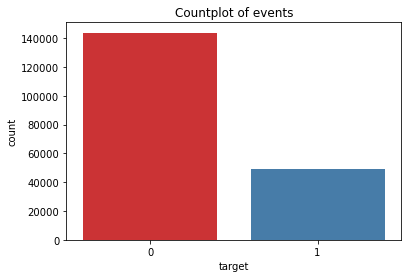

In [23]:
np.float = float
sns.countplot(x='target', data=dataset, palette='Set1').set(title = "Countplot of events")

Text(0, 0.5, 'Number of Air alerts')

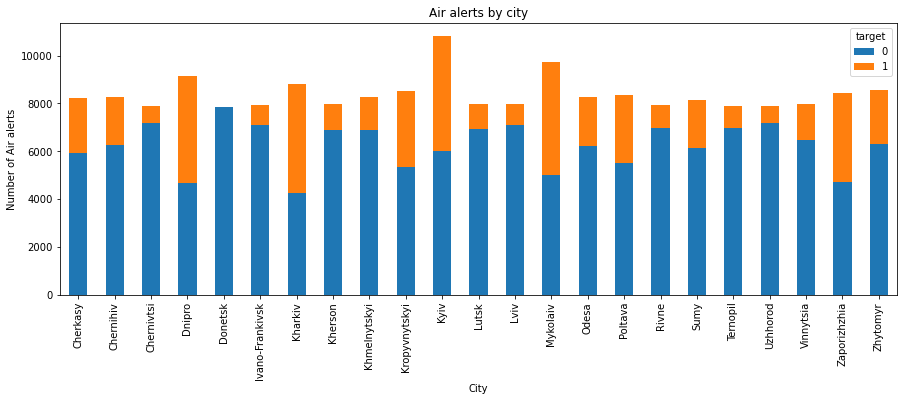

In [24]:
#%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
pd.crosstab(dataset['city'], dataset['target']).plot(kind='bar', stacked=True)
plt.title('Air alerts by city')
plt.xlabel('City')
plt.ylabel('Number of Air alerts')

In [25]:
# Create id column for each unique city
cities = dataset['city'].unique()
city_dict = {cities[i]: i+1 for i in range(len(cities))}
dataset['city_id'] = dataset['city'].map(city_dict)
dataset.drop('city', axis=1, inplace=True)

# Model Selection

In [73]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(random_state=5, class_weight="balanced", verbose=True)

# Support Vector Machines - Poor performance
from sklearn.svm import SVC
models['Support Vector Machines'] = SVC(random_state=5, class_weight="balanced", verbose=True)

# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
models['Stochastic Gradient Descent'] = SGDClassifier(random_state=5, class_weight="balanced", loss="log", verbose=True)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(random_state=5, class_weight="balanced", verbose=True)

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
models['AdaBoost'] = AdaBoostClassifier(random_state=5)


# XGBoost
from xgboost import XGBClassifier
models['XGBoost'] = XGBClassifier(random_state=5, objective='binary:logistic', booster='gbtree', verbose=2)

# k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['KNN'] = KNeighborsClassifier(n_neighbors=7)

In [74]:
models

{'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=5, verbose=True),
 'Support Vector Machines': SVC(class_weight='balanced', random_state=5, verbose=True),
 'Stochastic Gradient Descent': SGDClassifier(class_weight='balanced', loss='log', random_state=5, verbose=True),
 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=5, verbose=True),
 'AdaBoost': AdaBoostClassifier(random_state=5),
 'XGBoost': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=N

In [77]:
# Save the models to disk
count = 1
for model_name in models.keys():
    filename = f'{count}__{model_name}__v0.pkl'
    pickle.dump(models[model_name], open(filename, 'wb'))
    count += 1
    print(f"{filename} saved")

1__Logistic Regression__v0.pkl saved
2__Support Vector Machines__v0.pkl saved
3__Stochastic Gradient Descent__v0.pkl saved
4__Random Forest__v0.pkl saved
5__AdaBoost__v0.pkl saved
6__XGBoost__v0.pkl saved
7__KNN__v0.pkl saved


# Model Training

In [53]:
min_date = dataset['day_datetime'].min()
max_date = dataset['day_datetime'].max()
print("Min:", min_date, "Max:", max_date)

Min: 2022-02-25 00:00:00 Max: 2023-01-20 00:00:00


In [54]:
train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Timestamp('2022-10-29 18:00:00')

In [55]:
train_df = dataset[dataset['day_datetime'] <= train_cutoff]
test_df = dataset[dataset['day_datetime'] > train_cutoff]

In [56]:
# Split the dataset into features (X) and target (y)
X_train, X_test = train_df.drop(columns=['target', 'day_datetime']), test_df.drop(columns=['target', 'day_datetime'])
y_train, y_test = train_df['target'], test_df['target']

In [57]:
# Train models
predict_dict, predict_proba_dict = {}, {}

for key in models.keys():
    print(key)

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predict_dict[key] = models[key].predict(X_test)
    predict_proba_dict[key] = models[key].predict_proba(X_test)[:, 1]

Logistic Regression


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.5s finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\valida

Stochastic Gradient Descent


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


-- Epoch 1
Norm: 101486.52, NNZs: 765, Bias: 213.293721, T: 147734, Avg. loss: 663679919.048180
Total training time: 0.51 seconds.
-- Epoch 2
Norm: 97812.50, NNZs: 765, Bias: 240.093881, T: 295468, Avg. loss: 89534915.843517
Total training time: 1.13 seconds.
-- Epoch 3
Norm: 93046.41, NNZs: 765, Bias: 253.943407, T: 443202, Avg. loss: 51537038.516701
Total training time: 1.60 seconds.
-- Epoch 4
Norm: 89413.18, NNZs: 765, Bias: 263.178806, T: 590936, Avg. loss: 36634669.862893
Total training time: 2.16 seconds.
-- Epoch 5
Norm: 85875.24, NNZs: 765, Bias: 269.710516, T: 738670, Avg. loss: 27986337.653683
Total training time: 2.70 seconds.
-- Epoch 6
Norm: 82640.96, NNZs: 765, Bias: 274.607890, T: 886404, Avg. loss: 22834912.258487
Total training time: 3.18 seconds.
-- Epoch 7
Norm: 79893.00, NNZs: 765, Bias: 278.569834, T: 1034138, Avg. loss: 19071048.050204
Total training time: 3.70 seconds.
-- Epoch 8
Norm: 77196.72, NNZs: 765, Bias: 281.685742, T: 1181872, Avg. loss: 16438931.345362

Norm: 27353.23, NNZs: 765, Bias: 300.439104, T: 9454976, Avg. loss: 1785567.870799
Total training time: 33.51 seconds.
-- Epoch 65
Norm: 27127.36, NNZs: 765, Bias: 300.447772, T: 9602710, Avg. loss: 1755463.097828
Total training time: 33.93 seconds.
-- Epoch 66
Norm: 26921.68, NNZs: 765, Bias: 300.464796, T: 9750444, Avg. loss: 1730898.539829
Total training time: 34.39 seconds.
-- Epoch 67
Norm: 26712.69, NNZs: 765, Bias: 300.474066, T: 9898178, Avg. loss: 1713998.988599
Total training time: 34.81 seconds.
-- Epoch 68
Norm: 26498.36, NNZs: 765, Bias: 300.478286, T: 10045912, Avg. loss: 1679968.963016
Total training time: 35.30 seconds.
-- Epoch 69
Norm: 26296.86, NNZs: 765, Bias: 300.482240, T: 10193646, Avg. loss: 1653182.128860
Total training time: 35.81 seconds.
-- Epoch 70
Norm: 26091.42, NNZs: 765, Bias: 300.480881, T: 10341380, Avg. loss: 1628234.448639
Total training time: 36.37 seconds.
-- Epoch 71
Norm: 25901.03, NNZs: 765, Bias: 300.483401, T: 10489114, Avg. loss: 1606577.058

Norm: 20525.08, NNZs: 765, Bias: 300.485981, T: 18614484, Avg. loss: 884631.832453
Total training time: 63.70 seconds.
-- Epoch 127
Norm: 20470.58, NNZs: 765, Bias: 300.480415, T: 18762218, Avg. loss: 878041.460563
Total training time: 64.12 seconds.
-- Epoch 128
Norm: 20425.28, NNZs: 765, Bias: 300.481326, T: 18909952, Avg. loss: 867371.774350
Total training time: 64.58 seconds.
-- Epoch 129
Norm: 20381.29, NNZs: 765, Bias: 300.481319, T: 19057686, Avg. loss: 857202.505854
Total training time: 65.03 seconds.
-- Epoch 130
Norm: 20340.03, NNZs: 765, Bias: 300.484632, T: 19205420, Avg. loss: 853896.151380
Total training time: 65.50 seconds.
-- Epoch 131
Norm: 20296.29, NNZs: 765, Bias: 300.483845, T: 19353154, Avg. loss: 843606.351504
Total training time: 65.92 seconds.
-- Epoch 132
Norm: 20257.13, NNZs: 765, Bias: 300.487595, T: 19500888, Avg. loss: 842315.667689
Total training time: 66.36 seconds.
-- Epoch 133
Norm: 20212.22, NNZs: 765, Bias: 300.484701, T: 19648622, Avg. loss: 837482.

Norm: 18633.43, NNZs: 765, Bias: 300.494948, T: 27921726, Avg. loss: 572590.417337
Total training time: 94.75 seconds.
-- Epoch 190
Norm: 18614.13, NNZs: 765, Bias: 300.493689, T: 28069460, Avg. loss: 570901.618076
Total training time: 95.26 seconds.
-- Epoch 191
Norm: 18593.70, NNZs: 765, Bias: 300.491320, T: 28217194, Avg. loss: 570253.189762
Total training time: 95.80 seconds.
-- Epoch 192
Norm: 18574.48, NNZs: 765, Bias: 300.492362, T: 28364928, Avg. loss: 562382.438957
Total training time: 96.35 seconds.
-- Epoch 193
Norm: 18554.12, NNZs: 765, Bias: 300.490195, T: 28512662, Avg. loss: 560726.481841
Total training time: 96.89 seconds.
-- Epoch 194
Norm: 18534.46, NNZs: 765, Bias: 300.489553, T: 28660396, Avg. loss: 555465.049753
Total training time: 97.40 seconds.
-- Epoch 195
Norm: 18518.21, NNZs: 765, Bias: 300.492347, T: 28808130, Avg. loss: 552048.283139
Total training time: 97.93 seconds.
-- Epoch 196
Norm: 18500.43, NNZs: 765, Bias: 300.493053, T: 28955864, Avg. loss: 548565.

Norm: 17702.81, NNZs: 765, Bias: 300.480489, T: 37081234, Avg. loss: 421779.680550
Total training time: 128.14 seconds.
-- Epoch 252
Norm: 17688.81, NNZs: 765, Bias: 300.477776, T: 37228968, Avg. loss: 417995.013500
Total training time: 128.62 seconds.
-- Epoch 253
Norm: 17677.74, NNZs: 765, Bias: 300.477594, T: 37376702, Avg. loss: 417405.635590
Total training time: 129.20 seconds.
-- Epoch 254
Norm: 17667.62, NNZs: 765, Bias: 300.479420, T: 37524436, Avg. loss: 415404.589393
Total training time: 129.71 seconds.
-- Epoch 255
Norm: 17656.06, NNZs: 765, Bias: 300.479048, T: 37672170, Avg. loss: 413974.564128
Total training time: 130.31 seconds.
-- Epoch 256
Norm: 17644.82, NNZs: 765, Bias: 300.479578, T: 37819904, Avg. loss: 411432.383826
Total training time: 130.79 seconds.
-- Epoch 257
Norm: 17633.33, NNZs: 765, Bias: 300.479118, T: 37967638, Avg. loss: 410344.710734
Total training time: 131.30 seconds.
-- Epoch 258
Norm: 17622.11, NNZs: 765, Bias: 300.479401, T: 38115372, Avg. loss: 

Norm: 17087.74, NNZs: 765, Bias: 300.466172, T: 46240742, Avg. loss: 329218.235027
Total training time: 159.97 seconds.
-- Epoch 314
Norm: 17080.08, NNZs: 765, Bias: 300.467036, T: 46388476, Avg. loss: 330483.276332
Total training time: 160.50 seconds.
-- Epoch 315
Norm: 17071.47, NNZs: 765, Bias: 300.466090, T: 46536210, Avg. loss: 327556.923118
Total training time: 161.04 seconds.
-- Epoch 316
Norm: 17063.93, NNZs: 765, Bias: 300.466441, T: 46683944, Avg. loss: 324691.335946
Total training time: 161.63 seconds.
-- Epoch 317
Norm: 17054.77, NNZs: 765, Bias: 300.464306, T: 46831678, Avg. loss: 326189.715224
Total training time: 162.18 seconds.
-- Epoch 318
Norm: 17046.22, NNZs: 765, Bias: 300.463457, T: 46979412, Avg. loss: 323650.492714
Total training time: 162.70 seconds.
-- Epoch 319
Norm: 17038.37, NNZs: 765, Bias: 300.463549, T: 47127146, Avg. loss: 325526.980346
Total training time: 163.26 seconds.
-- Epoch 320
Norm: 17031.90, NNZs: 765, Bias: 300.467525, T: 47274880, Avg. loss: 

Norm: 16624.38, NNZs: 765, Bias: 300.466346, T: 55400250, Avg. loss: 269583.222042
Total training time: 193.73 seconds.
-- Epoch 376
Norm: 16617.91, NNZs: 765, Bias: 300.466570, T: 55547984, Avg. loss: 269625.742343
Total training time: 194.31 seconds.
-- Epoch 377
Norm: 16609.95, NNZs: 765, Bias: 300.465119, T: 55695718, Avg. loss: 265407.485078
Total training time: 194.99 seconds.
-- Epoch 378
Norm: 16603.44, NNZs: 765, Bias: 300.464976, T: 55843452, Avg. loss: 267239.409901
Total training time: 195.48 seconds.
-- Epoch 379
Norm: 16596.86, NNZs: 765, Bias: 300.464436, T: 55991186, Avg. loss: 267350.392119
Total training time: 196.11 seconds.
-- Epoch 380
Norm: 16590.36, NNZs: 765, Bias: 300.464918, T: 56138920, Avg. loss: 264939.545032
Total training time: 196.78 seconds.
-- Epoch 381
Norm: 16583.46, NNZs: 765, Bias: 300.464438, T: 56286654, Avg. loss: 264822.092878
Total training time: 197.38 seconds.
-- Epoch 382
Norm: 16577.11, NNZs: 765, Bias: 300.464775, T: 56434388, Avg. loss: 

Norm: 16237.19, NNZs: 765, Bias: 300.461894, T: 64559758, Avg. loss: 226125.606399
Total training time: 227.95 seconds.
-- Epoch 438
Norm: 16231.47, NNZs: 765, Bias: 300.462493, T: 64707492, Avg. loss: 224732.897904
Total training time: 228.50 seconds.
-- Epoch 439
Norm: 16225.62, NNZs: 765, Bias: 300.461993, T: 64855226, Avg. loss: 224800.822667
Total training time: 228.99 seconds.
-- Epoch 440
Norm: 16219.58, NNZs: 765, Bias: 300.461642, T: 65002960, Avg. loss: 224381.897043
Total training time: 229.53 seconds.
-- Epoch 441
Norm: 16214.10, NNZs: 765, Bias: 300.463093, T: 65150694, Avg. loss: 223791.516106
Total training time: 230.02 seconds.
-- Epoch 442
Norm: 16207.96, NNZs: 765, Bias: 300.462344, T: 65298428, Avg. loss: 222570.080871
Total training time: 230.48 seconds.
-- Epoch 443
Norm: 16202.72, NNZs: 765, Bias: 300.463670, T: 65446162, Avg. loss: 223036.039068
Total training time: 230.95 seconds.
-- Epoch 444
Norm: 16197.07, NNZs: 765, Bias: 300.463852, T: 65593896, Avg. loss: 

Norm: 15897.06, NNZs: 765, Bias: 300.459107, T: 73719266, Avg. loss: 193667.385916
Total training time: 260.25 seconds.
-- Epoch 500
Norm: 15891.56, NNZs: 765, Bias: 300.458313, T: 73867000, Avg. loss: 193754.101778
Total training time: 260.75 seconds.
-- Epoch 501
Norm: 15886.51, NNZs: 765, Bias: 300.457905, T: 74014734, Avg. loss: 193789.382538
Total training time: 261.31 seconds.
-- Epoch 502
Norm: 15881.44, NNZs: 765, Bias: 300.457525, T: 74162468, Avg. loss: 192699.447006
Total training time: 261.82 seconds.
-- Epoch 503
Norm: 15876.70, NNZs: 765, Bias: 300.458563, T: 74310202, Avg. loss: 191823.687107
Total training time: 262.27 seconds.
-- Epoch 504
Norm: 15870.97, NNZs: 765, Bias: 300.457376, T: 74457936, Avg. loss: 191757.125409
Total training time: 262.80 seconds.
-- Epoch 505
Norm: 15865.53, NNZs: 765, Bias: 300.457550, T: 74605670, Avg. loss: 190705.692543
Total training time: 263.26 seconds.
-- Epoch 506
Norm: 15860.28, NNZs: 765, Bias: 300.457684, T: 74753404, Avg. loss: 

C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Random Forest


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.5min finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend Se

AdaBoost


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


XGBoost
[21:22:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

KNN


C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Stepan_Kalika\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


# Model Evaluation

In [61]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from scikitplot.helpers import binary_ks_curve
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [64]:
accuracy, precision, recall, f1, auc, pr_auc, loss, b_loss, ks_stat, matthews_corr = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predict_dict[key])
    precision[key] = precision_score(y_test, predict_dict[key])
    recall[key] = recall_score(y_test, predict_dict[key])
    f1[key] = f1_score(y_test, predict_dict[key])
    auc[key] = roc_auc_score(y_test, predict_proba_dict[key])
    pr_auc[key] = average_precision_score(y_test, predict_proba_dict[key])
    loss[key] = log_loss(y_test, predict_proba_dict[key])
    b_loss[key] = brier_score_loss(y_test, predict_proba_dict[key])
    ks_stat[key] =  binary_ks_curve(y_test, predict_proba_dict[key])[3]
    matthews_corr[key] = matthews_corrcoef(y_test, predict_dict[key])
    
columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'Log loss', 'Brier score', 'KS', 'MCC']   
df_model = pd.DataFrame(index=models.keys(), columns=columns)

df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()
df_model['ROC AUC'] = auc.values()
df_model['PR AUC'] = pr_auc.values()
df_model['Log loss'] = loss.values()
df_model['Brier score'] = b_loss.values()
df_model['KS'] = ks_stat.values()
df_model['MCC'] = matthews_corr.values()

df_model

,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC,Log loss,Brier score,KS,MCC
Logistic Regression,0.603173,0.276047,0.916539,0.424301,0.814560,0.399207,0.714755,0.250870,0.495720,0.337655
Stochastic Gradient Descent,0.837591,0.461584,0.107624,0.174550,0.542645,0.192640,5.853520,0.162409,0.085393,0.162129
Random Forest,0.842599,0.821192,0.017220,0.033732,0.930593,0.724399,0.304765,0.090708,0.782437,0.104686
AdaBoost,0.920036,0.754391,0.739619,0.746932,0.956586,0.838153,0.640472,0.223718,0.844097,0.699502
XGBoost,0.915827,0.774443,0.666574,0.716471,0.960518,0.799026,0.314300,0.071240,0.828404,0.669962
KNN,0.762901,0.156053,0.110262,0.129221,0.477688,0.157233,3.537876,0.192079,0.002374,-0.003404


Confusion matrix for Logistic Regression


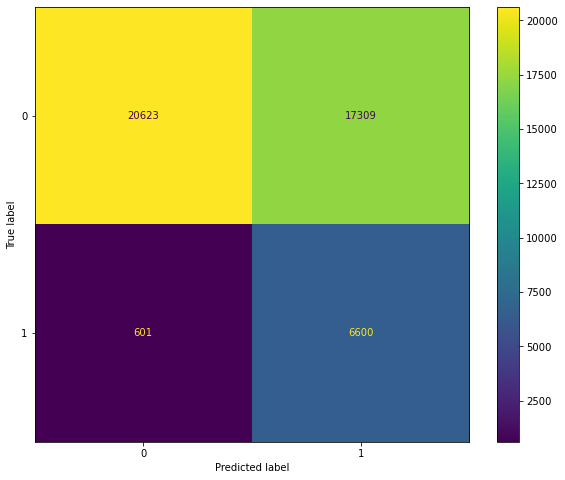

Confusion matrix for Stochastic Gradient Descent


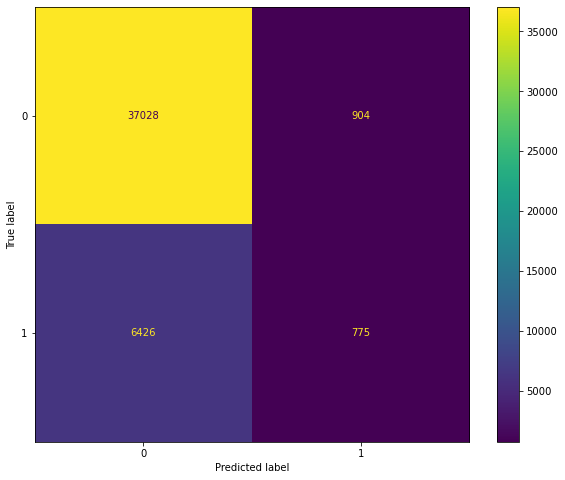

Confusion matrix for Random Forest


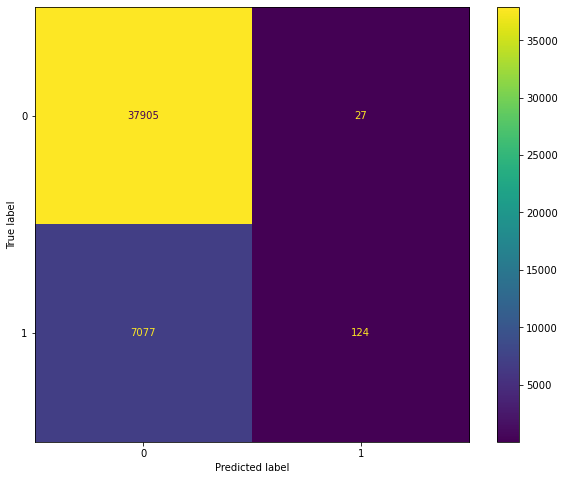

Confusion matrix for AdaBoost


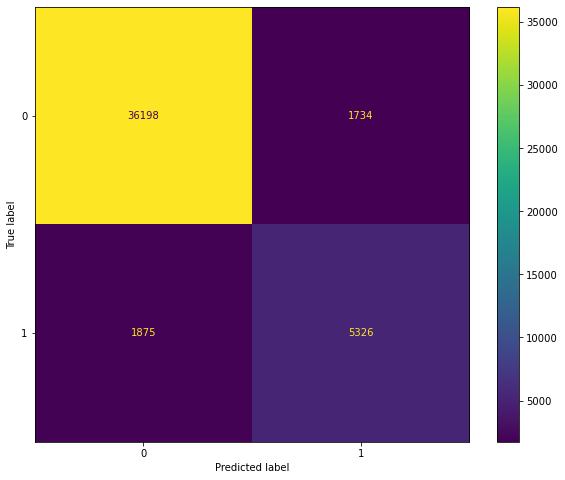

Confusion matrix for XGBoost


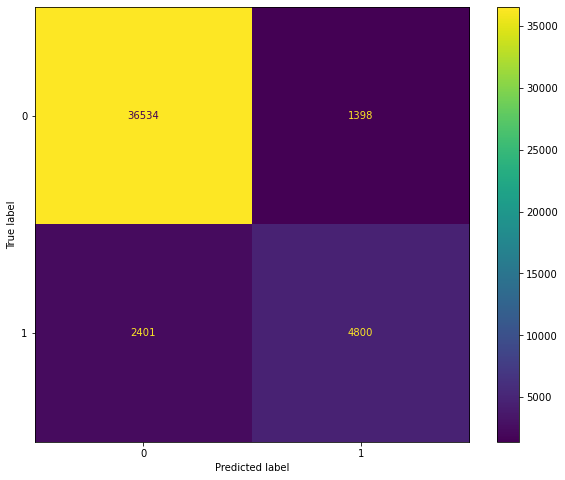

Confusion matrix for KNN


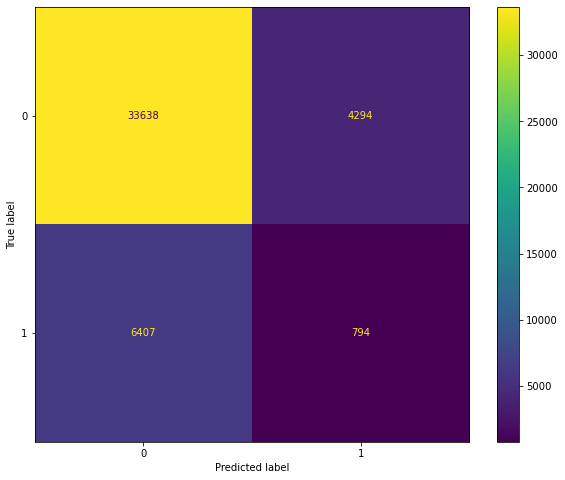

In [65]:
# Generate confusion matrix plots
for key in models.keys():
    print(f"Confusion matrix for {key}")
    
    matrix = confusion_matrix(y_test, predict_dict[key])
    cm = confusion_matrix(y_test, predict_dict[key], labels=models[key].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[key].classes_)
    disp.plot()
    plt.show()

In [66]:
for key in models.keys():
    print(f"Classification report for {key}")
    print(classification_report(y_test, predict_dict[key]))
    print("=====================================================")

Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.54      0.70     37932
           1       0.28      0.92      0.42      7201

    accuracy                           0.60     45133
   macro avg       0.62      0.73      0.56     45133
weighted avg       0.86      0.60      0.65     45133

Classification report for Stochastic Gradient Descent
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     37932
           1       0.46      0.11      0.17      7201

    accuracy                           0.84     45133
   macro avg       0.66      0.54      0.54     45133
weighted avg       0.79      0.84      0.79     45133

Classification report for Random Forest
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     37932
           1       0.82      0.02      0.03      7201

    accuracy                           0.8

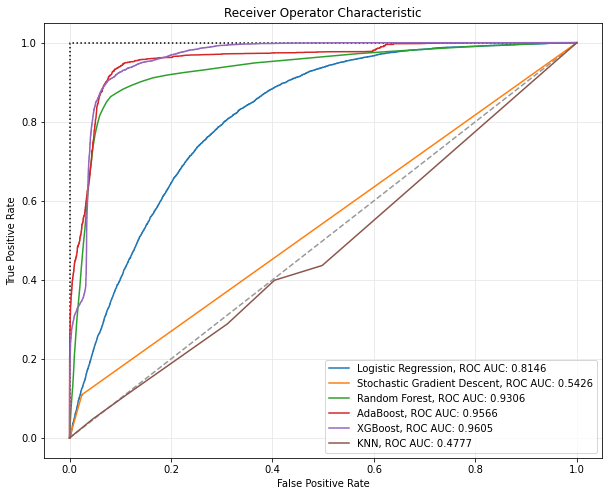

In [67]:
# ROC curves
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#set up plotting area
plt.rcParams["figure.figsize"] = [10, 8]
plt.figure(0).clf()

# roc curve for random and perfect models
plt.plot([0, 1], [0, 1], linestyle = '--', color = (0.6, 0.6, 0.6))
plt.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'black')

for key in models.keys():
    fpr, tpr, thresholds = roc_curve(y_test, predict_proba_dict[key])
    auc = round(roc_auc_score(y_test, predict_proba_dict[key]), 4)
    plt.plot(fpr, tpr, label=f"{key}, ROC AUC: {auc}")
 

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic')
plt.grid(color='0.9')
plt.legend()

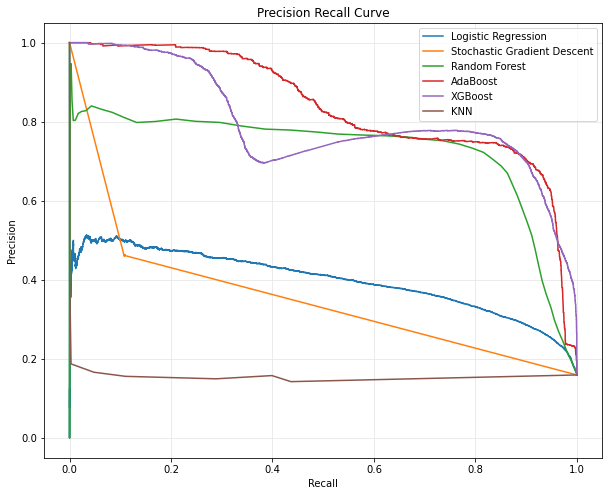

In [68]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#set up plotting area
plt.figure(0).clf()

for key in models.keys():
    precision, recall, thresholds = precision_recall_curve(y_test, predict_proba_dict[key])
    label = f'{key}'
    plt.plot(recall, precision, label = label)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')  
plt.ylabel('Precision')  
plt.title('Precision Recall Curve')
plt.grid(color='0.9')
plt.legend()